# Ultimate Take Home Challenge

This is the notebook for the relax take home challenge. The project has three tasks. The first task is EDA of a time series. The second task is designing an experiment and metric for a toll bridge problem between two cities. The third task is building a model to predict rider retention.

### Part 1: Exploratory Data Analysis:

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [530]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from library.sb_utils import save_file
from datetime import timedelta
import statsmodels.api as sm
import datetime as dt
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

Let's first load the data and inspect it.

In [531]:
# Load the data. 
logindata = pd.read_json('logins.json')

In [532]:
logindata.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [533]:
logindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


The data only records the login time. We need to count the number of logins in a period.

In [534]:
#Resample in 15 minute time interval:
logindata['count'] = 1
logindata.set_index('login_time', inplace=True)
logindata = logindata.resample('15T').sum()
logindata.head(5)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


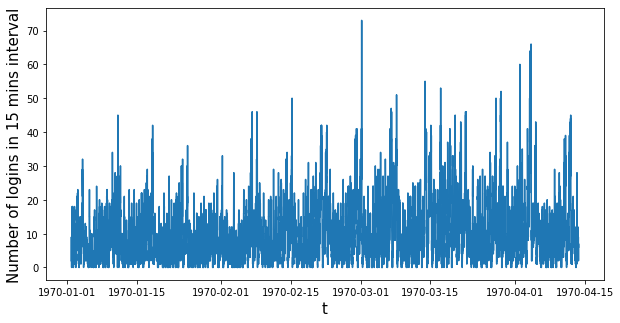

In [535]:
plt.figure(figsize=(10,5))
plt.plot(logindata)
plt.xlabel('t',fontsize=15)
plt.ylabel('Number of logins in 15 mins interval', fontsize=15)
plt.show()

There seems to be a trend but with too much noise. We should resample the data into daily to average out some of the noise.

In [536]:
logindatadaily=logindata.resample('D').sum()

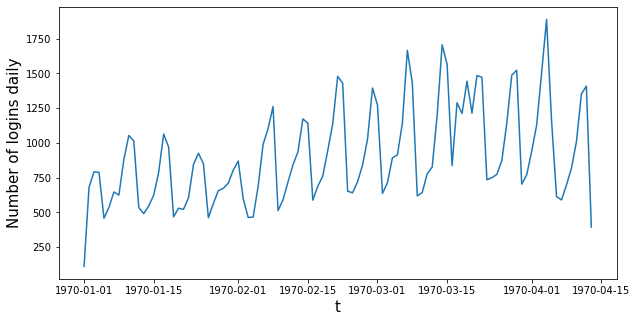

In [537]:
plt.figure(figsize=(10,5))
plt.plot(logindatadaily)
plt.xlabel('t',fontsize=15)
plt.ylabel('Number of logins daily', fontsize=15)
plt.show()

This is much better. We see that as we go from January to April, the number of login increases. In addition, there is a day in a week with much higher logins than the rest. We can try separate out the trend, seasonal, and noise of this data with decompose module in the statsmodel package. Since the seasonal variation does not seem to change much, we can use the additive model.

In [538]:
decomposition = sm.tsa.seasonal_decompose(logindatadaily, model='additive')
adjustmin=min(decomposition.seasonal)

The adjustmin is there to make sure the seasonal and trend are all positive. Let's check the trend.

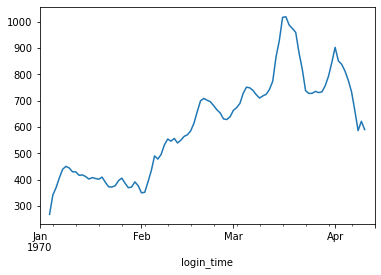

In [539]:
# Plot the trend
trendata=decomposition.trend+adjustmin
trendata.plot()
plt.show()

We see that activity did increase between March and April and started to decrease after.

Let's check the seasonal.

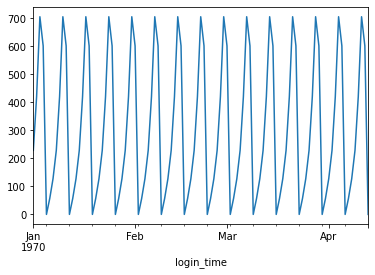

In [540]:
seasonaldata=(decomposition.seasonal-adjustmin)
seasonaldata.plot()
plt.show()

There is a day in the week with particular high activity. Let's change the x-axis to days of the week to investigate this.

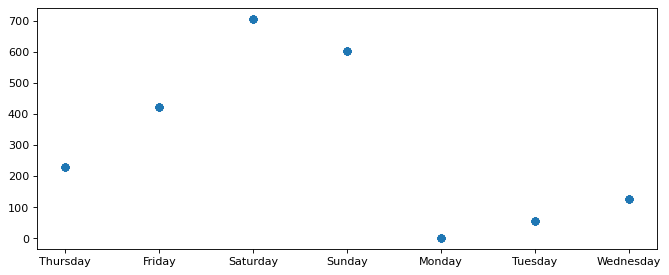

In [541]:
plt.figure(figsize=(10, 4), dpi=80)
plt.scatter(seasonaldata.index.day_name(),seasonaldata.values)
plt.show()

So the activity is the highest in the weekend, in particular Saturday. Monday is when the activity is the lowest.

In [542]:
seasonalde=pd.DataFrame({'date':seasonaldata.index.date, 'seasonal':seasonaldata.values})

In [543]:
seasonalde.head()

,date,seasonal
0,1970-01-01,228.897959
1,1970-01-02,420.908163
2,1970-01-03,706.236264
3,1970-01-04,602.204082
4,1970-01-05,0.000000


In [544]:
trendde=pd.DataFrame({'date':trendata.index.date, 'trend':trendata.values})

In [545]:
trendde=trendde.fillna(method='bfill')

In [546]:
trendde=trendde.fillna(method='ffill')

In [547]:
logindata['date']=logindata.index.date

In [548]:
logindata['time']=logindata.index.time

In [549]:
logindata.head()

,count,date,time
login_time,,,
1970-01-01 20:00:00,2,1970-01-01,20:00:00
1970-01-01 20:15:00,6,1970-01-01,20:15:00
1970-01-01 20:30:00,9,1970-01-01,20:30:00
1970-01-01 20:45:00,7,1970-01-01,20:45:00
1970-01-01 21:00:00,1,1970-01-01,21:00:00


In [550]:
logindata=logindata.merge(trendde, on='date', how='left')

In [551]:
logindata=logindata.merge(seasonalde, on='date', how='left')

In [552]:
logindata.head()

,count,date,time,trend,seasonal
0,2,1970-01-01,20:00:00,267.807356,228.897959
1,6,1970-01-01,20:15:00,267.807356,228.897959
2,9,1970-01-01,20:30:00,267.807356,228.897959
3,7,1970-01-01,20:45:00,267.807356,228.897959
4,1,1970-01-01,21:00:00,267.807356,228.897959


In [553]:
logindata['hourlytrend']=logindata['count']-(logindata['trend']+logindata['seasonal'])/(24*4)

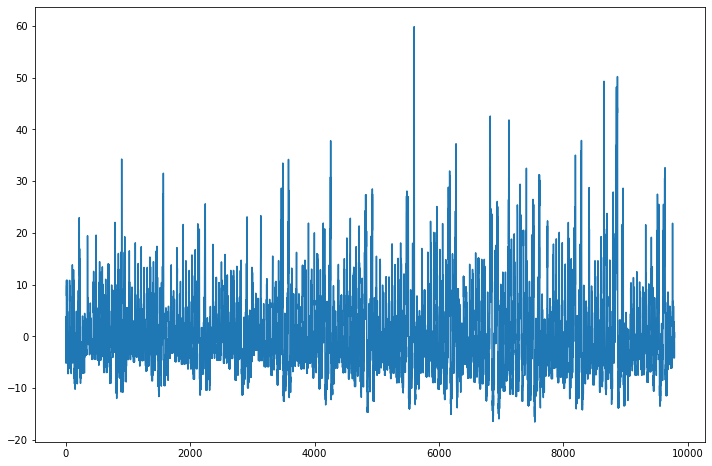

In [554]:
plt.figure(figsize=(12,8))
logindata['hourlytrend'].plot()
plt.show()

This figure indicates that there are periodic activities within the day. Let's average out the data to investigate it.

In [555]:
hourlychange=logindata.groupby('time')['hourlytrend'].sum()

In [556]:
timehour= [hourlychange.index[i].hour+hourlychange.index[i].minute/60 for i in range(len(hourlychange))]

In [557]:
ticklocation=[i*4 for i in range(24)]

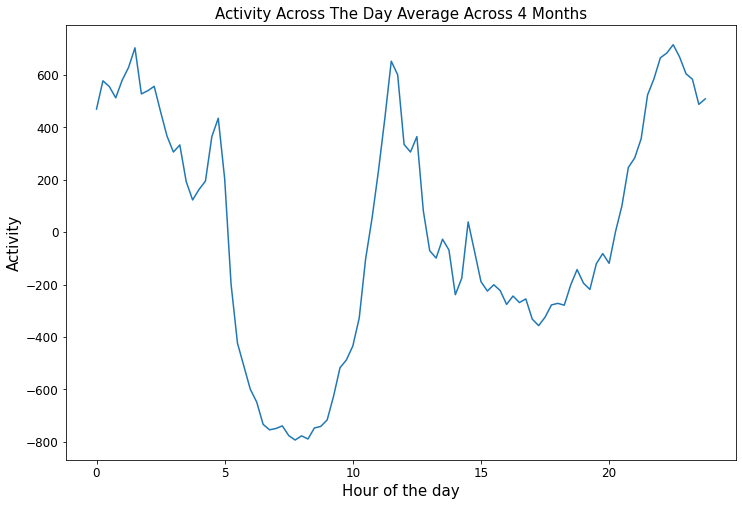

In [558]:
plt.figure(figsize=(12,8))
_=plt.plot(timehour,hourlychange.values)
plt.xlabel('Hour of the day',fontsize=15)
plt.ylabel('Activity',fontsize=15)
plt.title ('Activity Across The Day Average Across 4 Months', fontsize =15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From this, we see that the hours around midnight and noon have the most significant numbers of logins.

### Part 2: Experiment and metrics design:


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
how you will implement the experiment.
what statistical test(s) you will conduct to verify the significance of the observation.
how you would interpret the results and provide recommendations to the city operations team along with any caveats.

#### Solution:

##### Metric:
Ultimately, the cities want more **profit**. However, net profit can be contributed by a lot of factors. Thus, we have to be careful in examining where the profit is coming from and related to the toll bridge policy. In particular, with this policy, the city decides to lose the profit from the toll bridge in exchange for the profit from the activities between the two cities. Thus, in addition to using the profit alone, the city should also consider **the number of people traveling between the ridge** and **the increases in activity within the city**.

In short: Profit, amount of people traveling, and activity increase.

##### Experiment:
A straightforward experiment uses the A/B test. The control group would have to pay for the toll bridge while the other could travel freely between the cities. They would have to report how often they cross the bridge and their activities in the other city. To optimize the policy, they also have to report how their answer changes throughout the week, month. We then calculate the profits gained in these two groups to see which policy is better. One statistical test we can use is the t-test to see if the new policy's profit will generally outweigh the old one. However, since it will take a while for people from different cities to build connections, it might be long for the experiment to yield a favorable result for the new policy. We will have to monitor it carefully to optimize the policy.

### Part 3: Predictive modeling:

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

### Data Wrangling 

Let's first import the data.

In [559]:
ultimatedata = pd.read_json('ultimate_data_challenge.json')

In [560]:
ultimatedata.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [561]:
ultimatedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [562]:
ultimatedata.describe(include='all')

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,50000,50000.000000,50000,41878.000000,50000.000000,50000,49604,50000.000000,50000,50000.000000,50000.000000,49799.000000
unique,3,NaN,31,NaN,NaN,182,2,NaN,2,NaN,NaN,NaN
top,Winterfell,NaN,2014-01-18,NaN,NaN,2014-06-29,iPhone,NaN,False,NaN,NaN,NaN
freq,23336,NaN,2948,NaN,NaN,2036,34582,NaN,31146,NaN,NaN,NaN
mean,NaN,2.278200,NaN,4.601559,1.074764,NaN,NaN,8.849536,NaN,60.926084,5.796827,4.778158
std,NaN,3.792684,NaN,0.617338,0.222336,NaN,NaN,19.958811,NaN,37.081503,5.707357,0.446652
min,NaN,0.000000,NaN,1.000000,1.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,1.000000
25%,NaN,0.000000,NaN,4.300000,1.000000,NaN,NaN,0.000000,NaN,33.300000,2.420000,4.700000
50%,NaN,1.000000,NaN,4.900000,1.000000,NaN,NaN,0.000000,NaN,66.700000,3.880000,5.000000
75%,NaN,3.000000,NaN,5.000000,1.050000,NaN,NaN,8.600000,NaN,100.000000,6.940000,5.000000


There are some missing data for the "ave_rating_of_driver", "phone", and "ultimate_black_user". Let's check them out.

In [563]:
ultimatedata['phone'].head()

0     iPhone
1    Android
2     iPhone
3     iPhone
4    Android
Name: phone, dtype: object

In [564]:
ultimatedata['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [565]:
ultimatedata['avg_rating_by_driver'].head()

0    5.0
1    5.0
2    5.0
3    4.9
4    4.9
Name: avg_rating_by_driver, dtype: float64

<AxesSubplot:>

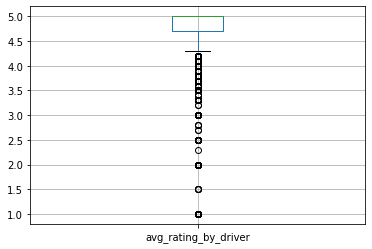

In [566]:
ultimatedata[['avg_rating_by_driver']].boxplot()

In [567]:
ultimatedata["avg_rating_of_driver"].head()

0    4.7
1    5.0
2    4.3
3    4.6
4    4.4
Name: avg_rating_of_driver, dtype: float64

<AxesSubplot:>

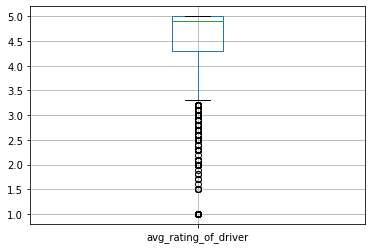

In [568]:
ultimatedata[["avg_rating_of_driver"]].boxplot()

The distributions in these columns seem fine. We can use these distributions to fill out the null values.

In [569]:
isnull = ultimatedata.avg_rating_of_driver.isnull()
sample = ultimatedata.avg_rating_of_driver.dropna().sample(isnull.sum(), replace=True).values
ultimatedata.loc[isnull, 'avg_rating_of_driver'] = sample

In [570]:
isnull = ultimatedata.phone.isnull()
sample = ultimatedata.phone.dropna().sample(isnull.sum(), replace=True).values
ultimatedata.loc[isnull, 'phone'] = sample

In [571]:
isnull = ultimatedata.avg_rating_by_driver.isnull()
sample = ultimatedata.avg_rating_by_driver.dropna().sample(isnull.sum(), replace=True).values
ultimatedata.loc[isnull, 'avg_rating_by_driver'] = sample

In [572]:
ultimatedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Next, we need to change the type of "signup_date" and "last_trip_date" to datetime.

In [573]:
ultimatedata['last_trip_date']=pd.to_datetime(ultimatedata['last_trip_date'])
ultimatedata['signup_date']=pd.to_datetime(ultimatedata['signup_date'])

The task asks us to find riders with activity at their 6th month. This will be a classify problem. But first, we need to calculate the days between the "last_trip_date" and "signup_date".

In [574]:
daychange=[(ultimatedata['last_trip_date'][i]-ultimatedata['signup_date'][i]).days for i in range(len(ultimatedata['last_trip_date']))]

In [575]:
ultimatedata['period_active']=daychange

Next, we need to label riders with a period_active bigger than 150 days (5 months) to be retain_rider.

In [576]:
ultimatedata['retain_rider']=0

In [577]:
ultimatedata.loc[ultimatedata['period_active']>150,'retain_rider']=1

In [578]:
ultimatedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  period_active           50000 non-null  int64 

### EDA 

Let's now look at the distribution of "period_active" and "retain_rider".

<AxesSubplot:xlabel='period_active', ylabel='Count'>

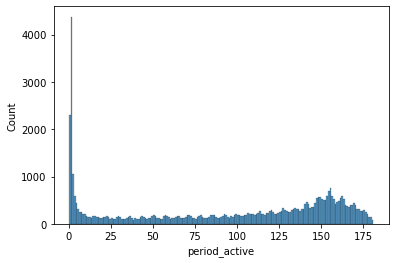

In [579]:
sns.histplot(ultimatedata['period_active'], binwidth=1)

<AxesSubplot:xlabel='retain_rider', ylabel='Count'>

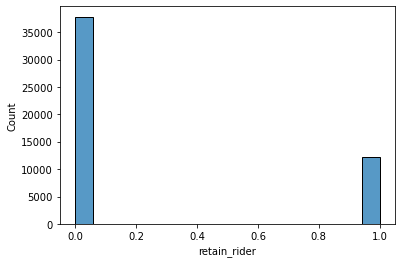

In [580]:
sns.histplot(ultimatedata['retain_rider'])

In [581]:
ultimatedata['retain_rider'].value_counts()

0    37802
1    12198
Name: retain_rider, dtype: int64

There are not many riders with the status "retain_rider" making the data imbalance. We will need to oversample the riders with the "retain_rider" status in our training set.

Let's check how the numerical features correlate.

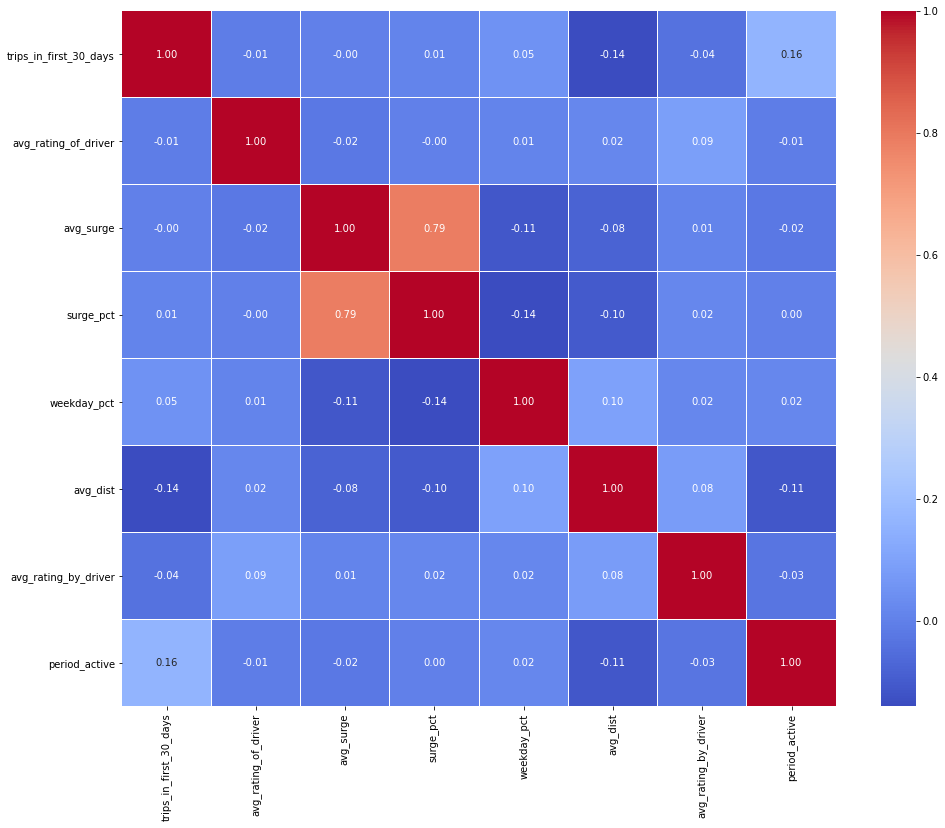

In [582]:
numcategories = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct'
            ,'avg_dist', 'avg_rating_by_driver','period_active']

corr = ultimatedata[numcategories].corr()
f, ax = plt.subplots(figsize=(16, 12))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)

From this, we see that "period_active" is most correlated with "trips_in_first_30_days" and anti-correlated with "ave_dist". Let's plot them for further inspection.

In [583]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'period_active', data=ultimatedata, alpha=0.5)
        ax.set(xlabel=col, ylabel='period_active')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [584]:
features = [col for col in ultimatedata.columns if col in ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct'
            ,'avg_dist', 'avg_rating_by_driver']]

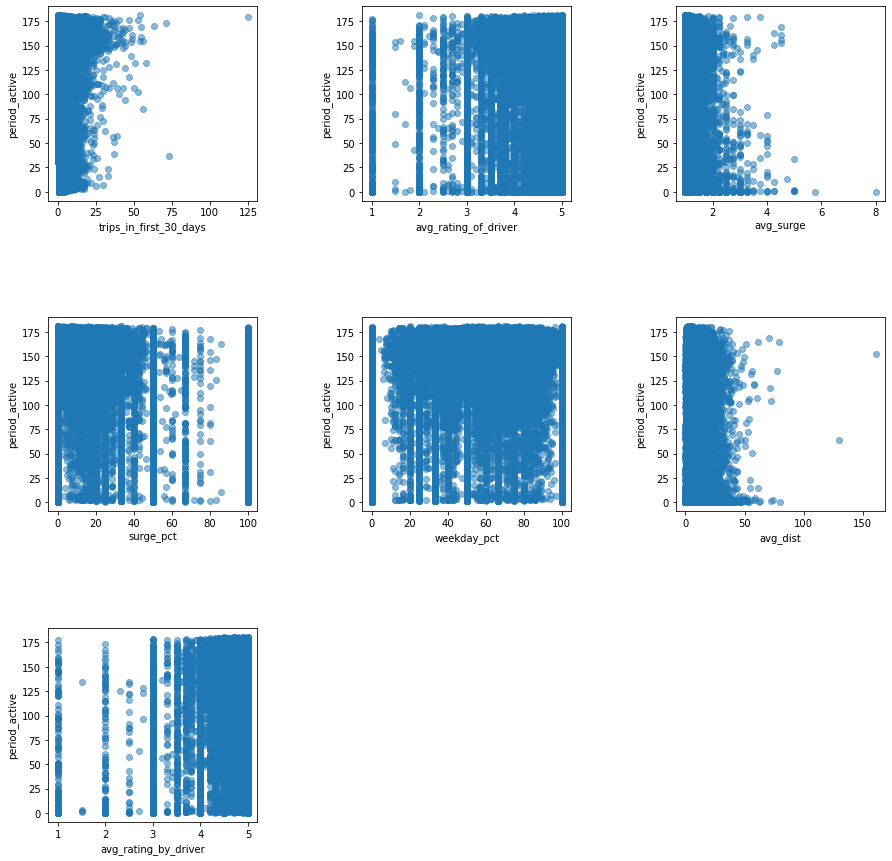

In [585]:
scatterplots(features, ncol=3, figsize=(15, 15))

Next, we will check categorical features using the chi-square test. But first, we need to create dummy variables for them.

In [586]:
ultimatedata = pd.get_dummies(ultimatedata, columns = ['city','phone', 'ultimate_black_user'])

In [587]:
ultimatedata.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,period_active,retain_rider,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,143,0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,96,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,170,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,47,0,0,0,1,1,0,1,0


Some of the categorical features are mutual exclusive. Thus, we will drop some of the columns to avoid correlation.

In [588]:
features_cols = ['phone_Android', 'city_Astapor', 'city_Winterfell'
       , 'ultimate_black_user_False']

In [589]:
for i in features_cols:
    print('The p value between retain_rider and '+i)
    contigency= pd.crosstab(ultimatedata['retain_rider'], ultimatedata[i])
    c, p, dof, expected = chi2_contingency(contigency)
    print(p)

The p value between retain_rider and phone_Android
0.0
The p value between retain_rider and city_Astapor
1.666898653606723e-192
The p value between retain_rider and city_Winterfell
3.75782619223787e-06
The p value between retain_rider and ultimate_black_user_False
3.0916823162424856e-277


It seems none of the categorical features is directly correlated with the "retain_rider" status.

### Modeling 

Let's build a classification model to indicate "retain_rider".

In [590]:
features_colsfinal=['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct'
            ,'avg_dist', 'avg_rating_by_driver','phone_Android', 'city_Astapor', 'city_Winterfell'
       , 'ultimate_black_user_False']

In [591]:
X = ultimatedata[features_colsfinal]
y = ultimatedata['retain_rider']

In [592]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=332)

In [593]:
from sklearn.utils import resample
train_data = pd.concat([X_train, y_train], axis=1)
negative = train_data[train_data['retain_rider']==0]
positive = train_data[train_data['retain_rider']==1]
pos_oversampled = resample(positive,replace=True,n_samples=len(negative),random_state=21)
oversampled = pd.concat([negative, pos_oversampled])

In [594]:
y_train=oversampled.retain_rider
X_train=oversampled.drop(columns='retain_rider')

In [595]:

rf = RandomForestClassifier(bootstrap=True, class_weight= 'balanced', n_estimators=50,criterion='entropy')
rf.fit(X_train, y_train)

#Predict using the model:

y_predict_rf = rf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

[[9560 1767]
 [1811 1862]]
0.7614666666666666


11


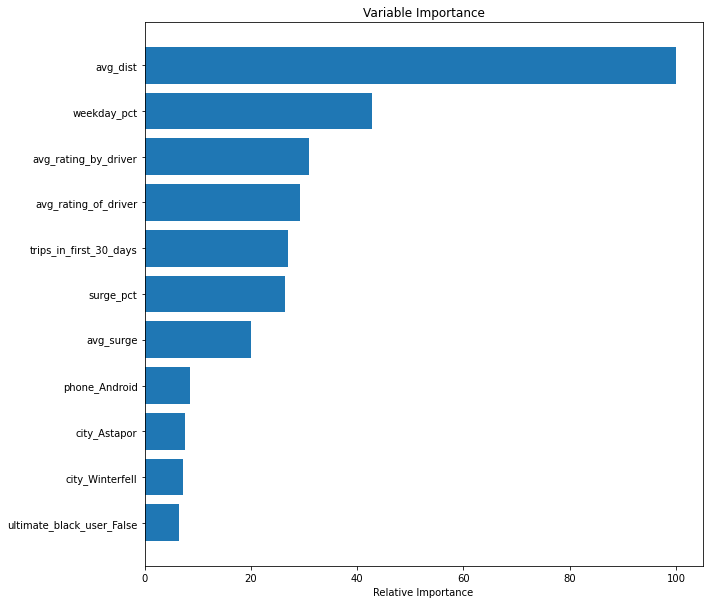

In [596]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Discussion 

We have built a model using RandomForest Classifier to predict whether a rider will retain or not. Based on our analysis, the most critical factors in indicating whether a rider has the "retain_rider" status are "avg_dist" and "weekday_pct." Riders with short "avg_dist" and high "weekday_pct" tend to retain. Despite its simplicity, our model performs exceptionally well with 76% accuracy.